In [1]:
import os
os.chdir("..")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from fix_data import add_label_T
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [3]:
hcc_smarts_df_train = pd.read_csv("data/SmartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt", sep = " ")
mcf_smarts_df_train = pd.read_csv("data/SmartSeq/MCF7_SmartS_Filtered_Normalised_3000_Data_train.txt", sep= " ")

hcc_smarts_df_train = add_label_T(hcc_smarts_df_train)
mcf_smarts_df_train = add_label_T(mcf_smarts_df_train)

X1 = hcc_smarts_df_train.loc[:,hcc_smarts_df_train.columns!='label']
X2 = mcf_smarts_df_train.loc[:,mcf_smarts_df_train.columns!='label']
y = hcc_smarts_df_train["label"]

In [4]:
svm = LinearSVC()
cross = cross_val_score(svm, X1, y, scoring="accuracy", cv=10)
print(f"Final accuracy = {round((sum(cross) / 10) * 100, 4)}%")

Final accuracy = 98.3333%


# Hyeperparameters

In [5]:
svm = LinearSVC()
p_grid = {'penalty': ['l1', 'l2'], 
          'loss':['squared_hinge', 'hinge'],
          "C": [0.00001, 0.0001, 0.001, 0.1 , 1, 10, 100, 1000, 10000],
          'dual': [True, False]
            }

gs_t = GridSearchCV(svm, param_grid = p_grid, cv=5, scoring= 'accuracy').fit(X1, y)
gs_t.best_params_

c:\Users\Samuele\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
180 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Samuele\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Samuele\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "c:\Users\Samuele\AppData\Local\Programs\Python\Python3

{'C': 0.1, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l1'}

In [6]:
svm_res_t = pd.DataFrame(gs_t.cv_results_)[["param_C", "param_loss", "param_penalty", "param_dual", "mean_test_score", "rank_test_score"]]
svm_res_t.sort_values(by="mean_test_score", ascending=False, inplace=True)
svm_res_t.iloc[:,:]


,param_C,param_loss,param_penalty,param_dual,mean_test_score,rank_test_score
36,1,squared_hinge,l1,False,0.994444,1
28,0.1,squared_hinge,l1,False,0.994444,1
44,10,squared_hinge,l1,False,0.994444,1
67,10000,hinge,l2,True,0.983333,4
65,10000,squared_hinge,l2,True,0.983333,4
...,...,...,...,...,...,...
63,1000,hinge,l2,False,NaN,37
64,10000,squared_hinge,l1,True,NaN,37
66,10000,hinge,l1,True,NaN,37
70,10000,hinge,l1,False,NaN,37


In [7]:
best_fit_true = {}
for i in [0.00001, 0.0001, 0.001, 0.1 , 1, 10, 100, 1000, 10000]:
    best_fit_true[f"{i}"] = max([svm_res_t.iloc[j,:].values for j in range(svm_res_t.shape[0]) if svm_res_t.iloc[j,0] == i], key= lambda x: x[4])[4]

best_fit_true

{'1e-05': 0.9833333333333334,
 '0.0001': 0.9833333333333334,
 '0.001': 0.9833333333333334,
 '0.1': 0.9944444444444445,
 '1': 0.9944444444444445,
 '10': 0.9944444444444445,
 '100': 0.9833333333333334,
 '1000': 0.9833333333333334,
 '10000': 0.9833333333333334}

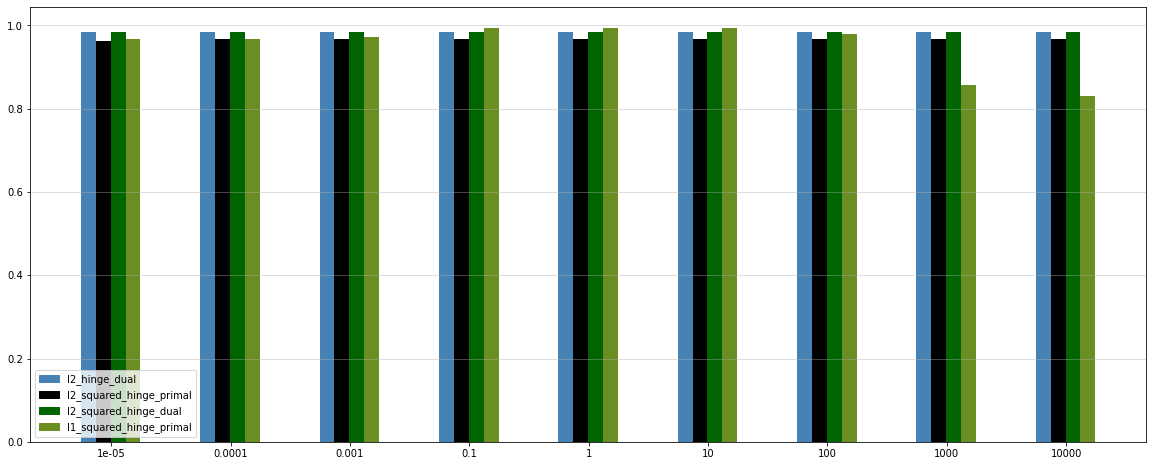

In [8]:
svm_res_t.sort_values(by="param_C", ascending=True, inplace=True)

fig, ax = plt.subplots(figsize=(20,8))


ax.bar([i for i in range(0,18,2)], [i for k,i in  enumerate(svm_res_t.loc[:,"mean_test_score"]) if (svm_res_t.iloc[k, 1] == "hinge" and svm_res_t.iloc[k, 2] == "l2" and svm_res_t.iloc[k, 3] == True)], width= 0.25, color= "steelblue")
ax.bar([i + 0.25 for i in range(0,18,2)], [i for k,i in  enumerate(svm_res_t.loc[:,"mean_test_score"]) if (svm_res_t.iloc[k, 1] == "squared_hinge" and svm_res_t.iloc[k, 2] == "l2" and svm_res_t.iloc[k, 3] == False)], width= 0.25, color= "black")
ax.bar([i + 0.25 + 0.25 for i in range(0,18,2)], [i for k,i in  enumerate(svm_res_t.loc[:,"mean_test_score"]) if (svm_res_t.iloc[k, 1] == "squared_hinge" and svm_res_t.iloc[k, 2] == "l2" and svm_res_t.iloc[k, 3] == True)], width= 0.25, color= "darkgreen")
ax.bar([i + 0.25 + 0.25 + 0.25 for i in range(0,18,2)], [i for k,i in  enumerate(svm_res_t.loc[:,"mean_test_score"]) if (svm_res_t.iloc[k, 1] == "squared_hinge" and svm_res_t.iloc[k, 2] == "l1" and svm_res_t.iloc[k, 3] == False)], width= 0.25, color= "olivedrab")

ax.set_xticks([i + 0.385 for i in range(0,18,2)], [0.00001, 0.0001, 0.001, 0.1 , 1, 10, 100, 1000, 10000])

ax.grid(axis= 'y', which= 'major', alpha=0.5)

colors = {"l2_hinge_dual": "steelblue", "l2_squared_hinge_primal": "black", "l2_squared_hinge_dual": "darkgreen", "l1_squared_hinge_primal": "olivedrab"}
label = list(colors.keys())
handle = [plt.Rectangle((0,0),2,2, color=colors[lab]) for lab in label]

ax.legend(handles= handle, labels= label, loc = "lower left")
plt.show() 

In [10]:
svm = LinearSVC(fit_intercept = False)
p_grid = {'penalty': ['l1', 'l2'], 
          'loss':['squared_hinge', 'hinge'],
          "C": [0.00001, 0.0001, 0.001, 0.1 , 1, 10, 100, 1000, 10000],
          'dual': [True, False]
            }

gs_f = GridSearchCV(svm, param_grid = p_grid, cv=5, scoring= 'accuracy').fit(X1, y)
gs_f.best_params_

c:\Users\Samuele\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
180 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Samuele\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Samuele\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "c:\Users\Samuele\AppData\Local\Programs\Python\Python3

{'C': 0.1, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l1'}

In [11]:
svm_res_f = pd.DataFrame(gs_f.cv_results_)[["param_C", "param_loss", "param_penalty", "param_dual", "mean_test_score", "rank_test_score"]]
svm_res_f.sort_values(by="mean_test_score", ascending=False, inplace=True)
svm_res_f.reset_index(drop= True)

,param_C,param_loss,param_penalty,param_dual,mean_test_score,rank_test_score
0,0.1,squared_hinge,l1,False,0.994444,1
1,1,squared_hinge,l1,False,0.988889,2
2,10,squared_hinge,l1,False,0.988889,2
3,10000,hinge,l2,True,0.983333,4
4,10000,squared_hinge,l2,True,0.983333,4
...,...,...,...,...,...,...
67,1000,hinge,l2,False,NaN,37
68,10000,squared_hinge,l1,True,NaN,37
69,10000,hinge,l1,True,NaN,37
70,10000,hinge,l1,False,NaN,37


In [12]:
best_fit_false = {}
for i in [0.00001, 0.0001, 0.001, 0.1 , 1, 10, 100, 1000, 10000]:
    best_fit_false[f"{i}"] = max([svm_res_f.iloc[j,:].values for j in range(svm_res_f.shape[0]) if svm_res_f.iloc[j,0] == i], key= lambda x: x[4])[4]


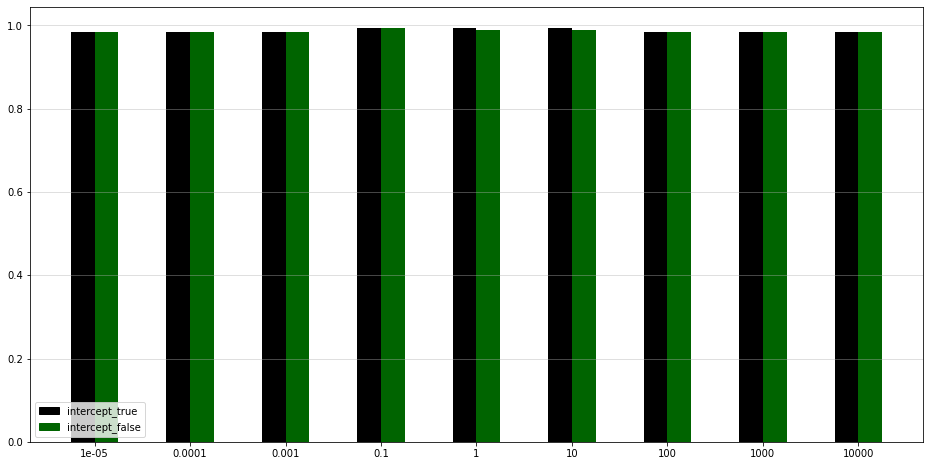

In [13]:
fig, ax = plt.subplots(figsize=(16,8))

ax.bar([i for i in range(9)], list(best_fit_true.values()), 0.25, color = "black")
ax.bar([i + 0.25 for i in range(9)], list(best_fit_false.values()), 0.25, color = "darkgreen")

ax.set_xticks([i + 0.125 for i in range(9)], [0.00001, 0.0001, 0.001, 0.1 , 1, 10, 100, 1000, 10000])
ax.grid(axis= 'y', which= 'major', alpha=0.5)

colors = {"intercept_true": "black", "intercept_false": "darkgreen"}
label = list(colors.keys())
handle = [plt.Rectangle((0,0),2,2, color=colors[lab]) for lab in label]

ax.legend(handles= handle, labels= label, loc = "lower left")
plt.show() 

In [15]:
svm = LinearSVC()
p_grid = {'penalty': ['l1', 'l2'], 
          'loss':['squared_hinge', 'hinge'],
          "C": [0.001, 0.1 , 1, 10],
          'dual': [True, False],
          'fit_intercept': [True],
          'class_weight': ['balanced', None],
          'multi_class': ['ovr', 'crammer_singer']
            }

gs_cr = GridSearchCV(svm, param_grid = p_grid, cv=5, scoring= 'accuracy').fit(X1, y)
gs_cr.best_params_

c:\Users\Samuele\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
160 fits failed out of a total of 640.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Samuele\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Samuele\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "c:\Users\Samuele\AppData\Local\Programs\Python\Python3

{'C': 0.1,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'loss': 'squared_hinge',
 'multi_class': 'ovr',
 'penalty': 'l1'}

In [16]:
svm_res_cr = pd.DataFrame(gs_cr.cv_results_)[["param_C", "param_loss", "param_penalty", "param_dual", "param_multi_class", "param_class_weight", "mean_test_score", "rank_test_score"]]
svm_res_cr.sort_values(by="mean_test_score", ascending=False, inplace=True)
svm_res_cr.reset_index(drop= True, inplace=True)
svm_res_cr.iloc[:10,:]


,param_C,param_loss,param_penalty,param_dual,param_multi_class,param_class_weight,mean_test_score,rank_test_score
0,1,squared_hinge,l1,False,ovr,None,0.994444,1
1,0.1,squared_hinge,l1,False,ovr,None,0.994444,1
2,0.1,squared_hinge,l1,False,ovr,balanced,0.994444,1
3,0.001,squared_hinge,l2,False,ovr,balanced,0.988889,4
4,1,squared_hinge,l1,False,ovr,balanced,0.988889,4
5,0.001,squared_hinge,l2,True,ovr,balanced,0.983333,6
6,1,squared_hinge,l2,True,ovr,None,0.983333,6
7,1,squared_hinge,l1,False,crammer_singer,None,0.983333,6
8,1,hinge,l2,True,crammer_singer,None,0.983333,6
9,1,hinge,l1,True,crammer_singer,None,0.983333,6


ValueError: x and y must have same first dimension, but have shapes (5,) and (4,)

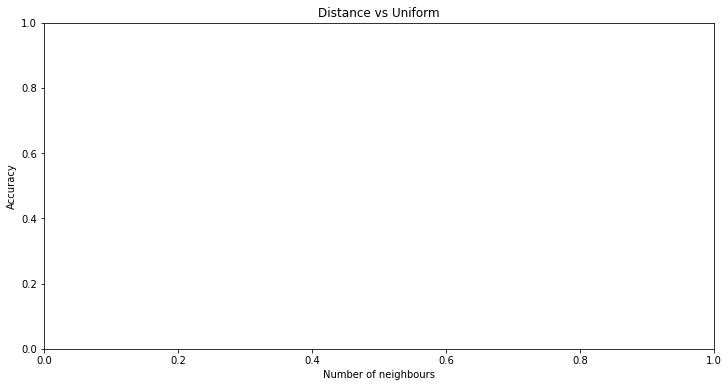

In [17]:
svm_res_cr.sort_values(by="param_C", ascending=True, inplace=True)
svm_res_cr.reset_index(drop= True, inplace=True)
fig, ax = plt.subplots(figsize=(12,6))

ax.set(xlabel='Number of neighbours', ylabel='Accuracy', title='Distance vs Uniform')

ax.plot([i for i in range(5)], [i for k,i in  enumerate(svm_res_cr.loc[:,"mean_test_score"]) if (svm_res_cr.iloc[k, 4] == "crammer_singer" and svm_res_cr.iloc[k, 1] == "squared_hinge" and svm_res_cr.iloc[k, 2] == "l2" and svm_res_cr.iloc[k, 3] == True and svm_res_cr.iloc[k, 5] == "balanced")], color= "black")
ax.plot([i for i in range(5)], [i for k,i in  enumerate(svm_res_cr.loc[:,"mean_test_score"]) if (svm_res_cr.iloc[k, 4] == "ovr" and svm_res_cr.iloc[k, 1] == "hinge" and svm_res_cr.iloc[k, 2] == "l2" and svm_res_cr.iloc[k, 3] == True and svm_res_cr.iloc[k, 5] == "balanced")], color= "green")
ax.plot([i for i in range(5)], [i for k,i in  enumerate(svm_res_cr.loc[:,"mean_test_score"]) if (svm_res_cr.iloc[k, 4] == "crammer_singer" and svm_res_cr.iloc[k, 1] == "squared_hinge" and svm_res_cr.iloc[k, 2] == "l2" and svm_res_cr.iloc[k, 3] == True and svm_res_cr.iloc[k, 5] == None)], color= "brown")
ax.plot([i for i in range(5)], [i for k,i in  enumerate(svm_res_cr.loc[:,"mean_test_score"]) if (svm_res_cr.iloc[k, 4] == "ovr" and svm_res_cr.iloc[k, 1] == "hinge" and svm_res_cr.iloc[k, 2] == "l2" and svm_res_cr.iloc[k, 3] == True and svm_res_cr.iloc[k, 5] == None)], color= "blue")

ax.set_xticks([i for i in range(5)], [0.001, 0.1 , 1, 10, 100])
ax.grid(axis= 'x', which= 'major')

colors= {'crammer_singer_bal':"black", 'ovr_bal':'green', "crammer_singer_Nan": "brown", "ovr_Nan": "blue"}
label = list(colors.keys())
handle = [plt.Rectangle((0,0),2,2, color=colors[lab]) for lab in label]

ax.legend(handles= handle, labels= label, loc = 0)

In [18]:
svm = LinearSVC()
p_grid = {'penalty': ['l1'], 
          'loss':['squared_hinge'],
          "C": [0.1 , 1],
          'dual': [False],
          'fit_intercept': [True],
          'class_weight': ['balanced', None],
          'multi_class': ['ovr'],
          'intercept_scaling': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
            }

gsi = GridSearchCV(svm, param_grid = p_grid, cv=5, scoring= 'accuracy').fit(X1, y)
gsi.best_params_

{'C': 0.1,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1e-05,
 'loss': 'squared_hinge',
 'multi_class': 'ovr',
 'penalty': 'l1'}

In [19]:
svm_res_i = pd.DataFrame(gsi.cv_results_)[["param_C", "param_loss", "param_penalty", "param_dual", "param_multi_class", "param_class_weight", "param_intercept_scaling", "mean_test_score", "rank_test_score"]]
svm_res_i.sort_values(by="mean_test_score", ascending=False, inplace=True)
svm_res_i.reset_index(drop= True, inplace=True)
svm_res_i.iloc[:,:]

,param_C,param_loss,param_penalty,param_dual,param_multi_class,param_class_weight,param_intercept_scaling,mean_test_score,rank_test_score
0,0.1,squared_hinge,l1,False,ovr,balanced,0.00001,0.994444,1
1,0.1,squared_hinge,l1,False,ovr,None,1,0.994444,1
2,1,squared_hinge,l1,False,ovr,None,1,0.994444,1
3,1,squared_hinge,l1,False,ovr,None,0.1,0.994444,1
4,1,squared_hinge,l1,False,ovr,None,0.01,0.994444,1
5,1,squared_hinge,l1,False,ovr,None,0.0001,0.994444,1
6,1,squared_hinge,l1,False,ovr,balanced,10,0.994444,1
7,1,squared_hinge,l1,False,ovr,balanced,1,0.994444,1
8,1,squared_hinge,l1,False,ovr,balanced,0.01,0.994444,1
9,1,squared_hinge,l1,False,ovr,balanced,0.001,0.994444,1


In [39]:
svm = LinearSVC()
p_grid = {'penalty': ['l1'], 
          'loss':['squared_hinge'],
          "C": [7, 8, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9],
          'dual': [False],
          'fit_intercept': [True],
          'class_weight': ['balanced', None],
          'multi_class': ['ovr'],
          'intercept_scaling': [0.00001, 0.0001, 0.001, 0.01],
          'max_iter': [10000]
            }

gsi = GridSearchCV(svm, param_grid = p_grid, cv=5, scoring= 'accuracy').fit(X1, y)
gsi.best_params_

In [36]:
svm_res_c = pd.DataFrame(gsi.cv_results_)[["param_C", "param_loss", "param_penalty", "param_dual", "param_multi_class", "param_class_weight", "param_intercept_scaling", "mean_test_score", "rank_test_score"]]
svm_res_c.sort_values(by="mean_test_score", ascending=False, inplace=True)
svm_res_c.reset_index(drop= True, inplace=True)
svm_res_c.iloc[:20,:]

,param_C,param_loss,param_penalty,param_dual,param_multi_class,param_class_weight,param_intercept_scaling,mean_test_score,rank_test_score
0,8.3,squared_hinge,l1,False,ovr,None,0.01,0.994595,1
1,8.9,squared_hinge,l1,False,ovr,None,0.01,0.994595,1
2,8.4,squared_hinge,l1,False,ovr,None,0.01,0.994444,3
3,8,squared_hinge,l1,False,ovr,None,0.01,0.994444,3
4,8.3,squared_hinge,l1,False,ovr,balanced,0.0001,0.994444,3
5,8.4,squared_hinge,l1,False,ovr,balanced,0.0001,0.994444,3
6,8.4,squared_hinge,l1,False,ovr,None,0.00001,0.994444,3
7,8.4,squared_hinge,l1,False,ovr,None,0.0001,0.994444,3
8,8.4,squared_hinge,l1,False,ovr,None,0.001,0.994444,3
9,8.5,squared_hinge,l1,False,ovr,None,0.001,0.994444,3


In [38]:
svm = LinearSVC(C=8.9, penalty= 'l1', dual=False, multi_class='ovr', class_weight=None, intercept_scaling= 0.0001)
cross = cross_val_score(svm, X1, y, scoring="accuracy", cv=10)
print(f"Final accuracy = {round((sum(cross) / 10) * 100, 4)}%")
print(cross)

Final accuracy = 99.4737%
[0.94736842 1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]
